# Multimodal Search

In this final exercise, we will learn how to use vector databases to search through images using natural language. 

We will be searching through an open source image dataset using an open source model called CLIP.
This model is able to encode both images and text into the same embedding space, allowing us to retrieve images that are similar to a user question.

In [1]:
pip install --quiet datasets gradio lancedb pandas transformers

Note: you may need to restart the kernel to use updated packages.


## Setup CLIP model

First, let's prepare the [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) model to encode the images.
We want to setup two things:
1. a model to encode the image
2. a processor to prepare the image to be encoded

Fill in the code below to initialize a pre-trained model and processor.

In [2]:
from transformers import CLIPModel, CLIPProcessor

MODEL_ID = "openai/clip-vit-base-patch32"

device = "cuda"

model = CLIPModel.from_pretrained(MODEL_ID).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

c:\Users\freda\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\freda\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\freda\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\freda\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new d

## Setup data model

The dataset itself has an image field and an integer label.
We'll also need an embedding vector (CLIP produces 512D vectors) field.

For this problem, please a field named "vector" to the Image class below
that is a 512D vector.

The image that comes out of the raw dataset is a PIL image. So we'll add
some conversion code between PIL and bytes to make it easier for serde.

In [3]:
import io

from lancedb.pydantic import LanceModel, vector
import PIL

class Image(LanceModel):
    image: bytes
    label: int
    vector: vector(512)
        
    def to_pil(self):
        return PIL.Image.open(io.BytesIO(self.image))
    
    @classmethod
    def pil_to_bytes(cls, img) -> bytes:
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        return buf.getvalue()

## Image processing function

Next we will implement a function to process batches of data from the dataset.
We will be using the `zh-plus/tiny-imagenet` dataset from huggingface datasets.
This dataset has an `image` and a `label` column.

For this problem, please fill in the code to extract the image embeddings from
the image using the CLIP model.

In [4]:
def process_image(batch: dict) -> dict:
    image = processor(text=None, images=batch["image"], return_tensors="pt")[
        "pixel_values"
    ].to(device)
    
    # create the image embedding from the processed image and the model
    img_emb = model.get_image_features(image)
    
    batch["vector"] = img_emb.cuda()
    batch["image_bytes"] = [Image.pil_to_bytes(img) for img in batch["image"]]
    return batch

## Table creation

Please create a LanceDB table called `image_search` to store the image, label, and vector.

In [5]:
import lancedb
TABLE_NAME = "image_search"

db = lancedb.connect("~/.lancedb")
db.drop_table(TABLE_NAME, ignore_missing=True)
table = db.create_table(TABLE_NAME, schema=Image.to_arrow_schema())

## Adding data

Now we're ready to process the images and generate embeddings.
Please write a function called `datagen` that calls `process_image` on each image in the validation set (10K images) and return a list of Image instances.

**HINT**
1. You may find it faster to use the [dataset.map](https://huggingface.co/docs/datasets/process#map) function.
2. You'll want to store the `image_bytes` field that is returned by `process_image`.

In [6]:
from datasets import load_dataset

def datagen() -> list[Image]:
    dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
    batches = dataset.map(process_image, batched=True, batch_size=32)
    
    # return Image instances
    return [Image(image=b["image_bytes"],
                  label=b["label"],
                  vector=b["vector"]
                  )
            for b in batches]

Now call the function you just wrote and add the generated instances to the LanceDB table.  The following process can take up to 60 minutes to complete.

In [7]:
data = datagen()


c:\Users\freda\miniconda3\Lib\site-packages\dill\_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.Image'>.
  StockPickler.save(self, obj, save_persistent_id)
c:\Users\freda\miniconda3\Lib\site-packages\dill\_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.Image'>: __main__.Image has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<function process_image at 0x000001A58D5A5760> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
table.add(data)

## Encoding user queries

We have image embeddings, but how do we generate the embeddings for the user query?
Furthermore, how can we possibly have the same features between the image embeddings
and text embeddings. This is where the power of CLIP comes in.

Please write a function to turn user query text into an embedding
in the same latent space as the images. 

**HINT** 
You can refer to the [CLIPModel documention](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel)

In [9]:
from transformers import CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(MODEL_ID)
tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    
    # generate the text embeddings
    text_features = model.get_text_features(**inputs)
    
    return text_features.detach().numpy()[0]

c:\Users\freda\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\freda\miniconda3\Lib\site-packages\transformers\modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.

## Core search function

Now let's write the core search function `find_images`, that takes a text query as input, and returns a list of PIL images that's most similar to the query.

In [10]:
def find_images(query):
    
    # Generate the embedding for the query
    emb = embed_func(query)
    
    # Search for the closest 9 images
    rs =table.search(emb).limit(9).to_pydantic(Image)
    
    # Return PIL instances for visualization
    return [m.to_pil() for m in rs]

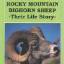

In [18]:
find_images("dog")[0]

## Create an App

Let's use gradio to create a small app to search through the images.
The code below has been completed for you:
1. Created a [text input](https://www.gradio.app/docs/textbox) where the user can type in a query
2. Created a "Submit" [button](https://www.gradio.app/docs/button) that finds similar images to the input query and display the resulting images
3. A [Gallery component](https://www.gradio.app/docs/gallery) that displays the images

In [27]:
import gradio as gr


with gr.Blocks() as demo:
    with gr.Row():
        vector_query = gr.Textbox(value="fish", show_label=False)
        b1 = gr.Button("Submit")
    with gr.Row():
        gallery = gr.Gallery(
                label="Found images", show_label=False, elem_id="gallery"
            )
        
    b1.click(find_images, inputs=vector_query, outputs=gallery)
    
demo.launch(server_name="0.0.0.0", inline=True)

ERROR:    [Errno 10048] error while attempting to bind on address ('0.0.0.0', 7860): only one usage of each socket address (protocol/network address/port) is normally permitted
ERROR:    [Errno 10048] error while attempting to bind on address ('0.0.0.0', 7861): only one usage of each socket address (protocol/network address/port) is normally permitted
ERROR:    [Errno 10048] error while attempting to bind on address ('0.0.0.0', 7862): only one usage of each socket address (protocol/network address/port) is normally permitted
ERROR:    [Errno 10048] error while attempting to bind on address ('0.0.0.0', 7863): only one usage of each socket address (protocol/network address/port) is normally permitted


* Running on local URL:  http://0.0.0.0:7864

To create a public link, set `share=True` in `launch()`.


To view the interface, click on the **Links** button at the bottom of the workspace window.  Then click on **gradio**.  This will open a new browser window with the interface.

Now try a bunch of different queries and see the results.
By default CLIP search results leave a lot of room for improvement. More advanced applications in this space can improve these results in a number ways like retraining the model with your own dataset, your own labels, and using image and text vectors to train the index. The details are however beyond the scope of this lesson.

## Summary

Congrats! 

Through this exercise, you learned how to use CLIP to generate image and text embeddings. You've mastered how to use vector databases to enable searching through images using natural language. And you even created a simple app to show off your work. 

Great job!